In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy.stats import multivariate_normal
import logging
import seaborn as sns
import pickle
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
#tips = sns.load_dataset("tips")
sns.set()

from qiskit.circuit.library import TwoLocal
from qiskit.opflow import X, Y, Z, I   
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit import *
from qiskit.algorithms.optimizers import COBYLA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import VQE, QAOA
from qiskit.opflow.primitive_ops import PauliSumOp
from qiskit.circuit import Parameter, QuantumCircuit
from qiskit.visualization.array import array_to_latex

In [5]:
# The coreset has been generated in a separate file

# This coreset represents data stemming from two 2-variate normal distributions with the same covariance matrix, 
# but with different mean vectors
coreset = np.array([[ 6.40655667,  0.60980874],
       [-0.47163091,  0.43107638],
       [ 0.52338476, -0.48768696],
       [ 8.3919823 ,  0.19121014],
       [ 1.02084332, -0.2261193 ],
       [ 6.40101943,  2.47664102]])
weights = np.array([216.06327648, 239.04561676, 215.54632493, 143.20444838, 218.40527156, 198.89116006])

# coreset m=10
coreset_10 = np.array([[ 6.10228511,  0.90678181],
 [-1.0415264,   0.86401884],
 [-0.06834732, -1.31303904],
 [-0.09556048 , 0.67703221],
 [-0.92266988  ,0.80485552],
 [-0.68219638  ,0.52770102],
 [-0.16338492, -0.61980863],
 [ 7.2674842  , 0.62243058],
 [ 7.18889316  ,2.03707113],
 [ 0.55466217, -0.08366838]])
weights_10 = np.array([117.2751533,   77.32872806,  97.06313577,  90.20780496,  79.37211319,
  84.89990733,  97.53129661, 128.3729297,  118.3347353,  102.45331498])

coreset_10_2 = np.array([[ 4.89674881,  3.7820109 ],
       [-0.6209434 , -0.2792752 ],
       [-0.26700858,  0.29367271],
       [-0.35783766,  0.90775477],
       [ 8.97628924,  0.13486738],
       [ 8.64713403, -0.3337845 ],
       [-0.67813796,  0.86572696],
       [-0.09556048,  0.67703221],
       [ 6.18938225,  1.5893929 ],
       [ 6.14019117,  0.78758785]])

weights_10_2 = np.array([ 44.02135301, 105.90066979, 120.92101629, 105.52453291,
        69.59509856,  70.58515608,  96.06810198, 119.60578161,
       135.47122165, 136.68348156])

# uniform m=10
C_u_10 = np.array([[ 8.00084199, -0.25259377],
 [ 7.2056508 ,  0.85961412],
 [-1.01963001 , 0.91018975],
 [-1.0415264   ,0.86401884],
 [ 0.63256116  ,0.60848412],
 [-0.60727499  ,0.87728088],
 [ 6.10574983  ,1.83830362],
 [ 0.70371218 ,-0.92277669],
 [-0.32754922  ,0.3055998 ],
 [-0.39199497  ,0.43987462]])
w_u_10 = np.array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100.])

coreset_20 = np.array([[ 9.04595543,  0.76398631],
 [ 0.29668833, -0.50565199],
 [ 7.03369628,  0.17057499],
 [ 7.54897989, -0.33152797],
 [ 6.25426329,  1.60881123],
 [ 6.99531591,  1.73092668],
 [ 7.23890707,  0.6902507 ],
 [ 8.80920467, -0.26070077],
 [ 8.24973365,  0.50641734],
 [ 0.15890129, -1.06076122],
 [ 6.7175925,   1.08004129],
 [-0.16835734,  0.38263807],
 [ 5.49573446,  3.22743831],
 [ 8.14051086, -0.3524523 ],
 [ 0.07999963,  0.03896149],
 [ 8.69266438, -0.8535849 ],
 [ 6.29842586,  1.40313882],
 [ 7.33674042, -0.27134639],
 [-0.60316378,  0.84831966],
 [ 0.07999963,  0.03896149]])

weights_20 = np.array([18.54130357, 83.43829438, 19.94932643, 19.72608471, 63.16654409, 59.00333199,
 60.06238395, 18.8903017,  19.13052623, 83.52102401, 62.1285772,  80.45821847,
 60.60571149, 19.35208841, 81.97735347, 19.03485201, 63.5333501,  19.84704775,
 77.68828788, 81.97735347])

C_u_20 = np.array([[ 7.22792827,  1.1795779 ],
 [-0.67433386,  1.1891456 ],
 [ 0.1527473,  -0.26139049],
 [-1.02419956,  0.84552923],
 [ 0.56792185, -0.23170577],
 [-1.86339735,  1.4813006 ],
 [ 7.26507177,  0.61128458],
 [ 0.55160676, -0.27031462],
 [ 1.4376166,  -0.72017368],
 [-0.09556048,  0.67703221],
 [-0.74573671,  0.60881123],
 [ 6.9906789,   1.642359  ],
 [ 1.22646736,  0.02805463],
 [ 6.48788718,  3.0852822 ],
 [ 7.86466362,  0.33831131],
 [ 6.02445838,  1.55314418],
 [ 9.09429547, -1.3545431 ],
 [ 1.28670114, -0.27471956],
 [-1.27991868,  1.61587359],
 [ 6.40470448,  1.23968806]])

w_u_20 = np.array([50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50.,
 50., 50.])

C_u_6 = np.array([[ 8.41499921, -0.01891339],
       [ 6.02916428,  2.08257184],
       [-0.59976036, -0.13689304],
       [ 0.73365886, -0.25659595],
       [-0.86842166,  1.11878062],
       [ 7.33674042, -0.27134639]])
w_u_6 = np.array([166.66666667, 166.66666667, 166.66666667, 166.66666667,
       166.66666667, 166.66666667])

Cs_uniform_10_3 = np.array([[-0.53803188, -0.22584001],
       [-0.50743422,  0.71493019],
       [ 6.26936271,  1.560738  ],
       [-1.37406074,  1.0064384 ],
       [ 8.26965801,  0.2834094 ],
       [-0.0620506 , -0.90648048],
       [ 1.48706092, -1.17531997],
       [-0.55294499,  0.75620277],
       [ 7.98432512, -0.09693664],
       [ 6.12425962,  1.22351264]])



In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

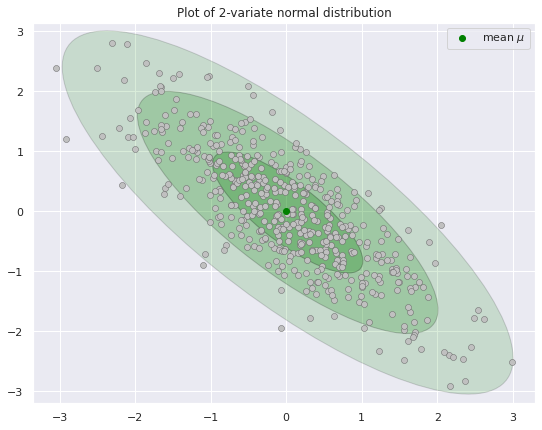

In [7]:
random_seed=1000
mean = np.array([0,0])
cov = np.array([[1, -0.8], [-0.8, 1]])

distr = multivariate_normal(cov = cov, mean = mean,
                                seed = random_seed)
     
    # Generating 5000 samples out of the
    # distribution
data = distr.rvs(size = 500)

fig, axs = plt.subplots(1, 1, figsize=(9, 7))
plt.plot(data[:,0],data[:,1], 'o',
             markeredgewidth = 0.5,
             color='silver',
             markeredgecolor = 'dimgrey')

confidence_ellipse(data[:,0], data[:,1], axs, n_std=3,edgecolor='black', alpha=0.15,facecolor='green')
confidence_ellipse(data[:,0], data[:,1], axs, n_std=2,edgecolor='black', alpha=0.2,facecolor='green')
confidence_ellipse(data[:,0], data[:,1], axs, n_std=1,edgecolor='black', alpha=0.25,facecolor='green')

plt.scatter(mean[0],mean[1],c='green',zorder=10, label="mean $\mu$")

plt.legend()
plt.title("Plot of 2-variate normal distribution")

plt.savefig("figures/normal_distribution.pdf")

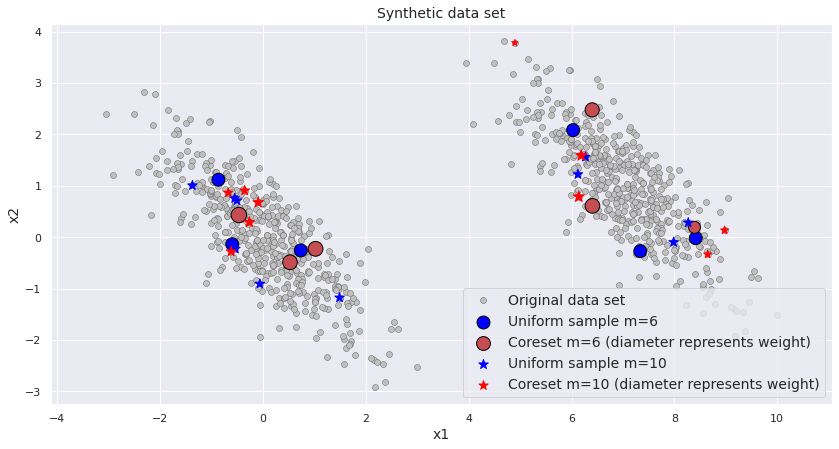

In [8]:
################# Visualisation #############################################
# Initializing the random seed
random_seed=1000

plt.rcParams['figure.figsize']=14,7
 
# List containing the variance
# covariance values
cov_val = [-0.8, -0.8] #0]#, 0.8]
 
# Setting mean of the distributino to
# be at (0,0)
mean = np.array([[0,0], [7,1]])#, [1,5]])

X = np.zeros((1000,2))
 
# Iterating over different covariance
# values
for idx, val in enumerate(cov_val):
    #plt.subplot(1,3,idx+1)
     
    # Initializing the covariance matrix
    cov = np.array([[1, val], [val, 1]])
     
    # Generating a Gaussian bivariate distribution
    # with given mean and covariance matrix
    distr = multivariate_normal(cov = cov, mean = mean[idx],
                                seed = random_seed)
     
    # Generating 5000 samples out of the
    # distribution
    data = distr.rvs(size = 500)
     
    X[500*idx:500*(idx+1)][:] = data
    # Plotting the generated samples
plt.plot(X[:,0],X[:,1], 'o',
             markeredgewidth = 0.5,
             color='silver',
             markeredgecolor = 'dimgrey')
    
    #plt.title(f'Covariance between x1 and x2 = {val}')

plt.scatter(C_u_6[:,0],C_u_6[:,1],s=w_u_6,c='blue',zorder=10,edgecolor='black')
plt.scatter(coreset[:,0],coreset[:,1],s=weights,c='r',zorder=10, edgecolor='black')

#plt.scatter(C_u_10[:,0],C_u_10[:,1],s=w_u_10,c='blue',zorder=10 , marker="*")
plt.scatter(Cs_uniform_10_3[:,0],Cs_uniform_10_3[:,1],s=w_u_10,c='blue',zorder=10 , marker="*")
plt.scatter(coreset_10_2[:,0],coreset_10_2[:,1],s=weights_10_2,c='red',zorder=10 , marker="*")


plt.xlabel('x1',fontsize=14)
plt.ylabel('x2',fontsize=14)
plt.axis('equal')
plt.legend(['Original data set', 'Uniform sample m=6','Coreset m=6 (diameter represents weight)', 'Uniform sample m=10', 'Coreset m=10 (diameter represents weight)'],fontsize=14)
plt.title("Synthetic data set",fontsize=14)

plt.savefig("figures/synthetic_data_coreset_uniform.pdf",bbox_inches='tight')

# Coreset m=6: TwoLocal ansatz

In [10]:
with open('results/results_general_ansatz_coreset_6.pickle', 'rb') as handle:
    results = pickle.load(handle)
color = []
coreset = coreset
for i in range(30):
    result = results[i]
    eigenvector = result.eigenstate if isinstance(result.eigenstate, np.ndarray) else result.eigenstate.to_matrix()
    #print(result.eigenvalue)
    probabilities = np.abs(eigenvector) ** 2
    n = probabilities.argmax()
    #print(bin(n)[2:].zfill(len(coreset)))
    
    
    if (bin(n)[2:].zfill(len(coreset)) == '100101' or bin(n)[2:].zfill(len(coreset)) == '011010'):
        color += ['b']
    else:
        color += ['blue']

/home/miriam/.local/lib/python3.8/site-packages/matplotlib/transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/miriam/.local/lib/python3.8/site-packages/matplotlib/transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


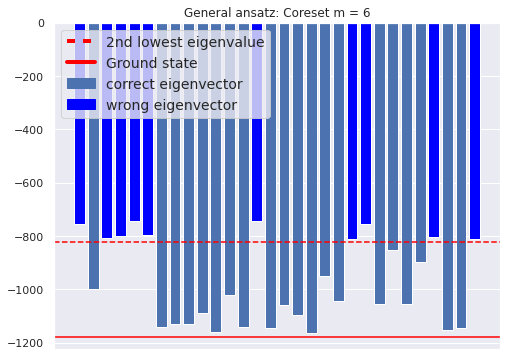

In [11]:
sns.set()
fig, ax = plt.subplots(figsize=(8, 6))

with open('results/results_general_ansatz_coreset_6.pickle', 'rb') as handle:
    results = pickle.load(handle)

costs = []
for i in range(30):
    costs += [results[i].eigenvalue]

ax.get_xaxis().set_visible(False)

plt.bar(range(1,31), costs, width=0.8,label='_nolegend_', color=color)
groundstate_patch = mpatches.Patch(color='red', linestyle='dashed', label='Ground state')
black_patch = mpatches.Patch(color='red', label='2nd lowest eigenvalue')
groundstate_patch = mlines.Line2D([], [], linewidth=4, color='red',label='Ground state')
test = mlines.Line2D([], [], linewidth=4, linestyle="-", dashes=(2, 2),color='red',label='2nd lowest eigenvalue')
black_patch = mpatches.Patch(color='b', label='correct eigenvector')
wrong = mpatches.Patch(color='blue', label='wrong eigenvector')
plt.legend(handles=[test, groundstate_patch,black_patch,wrong],loc='upper left',frameon=True,fontsize=14)


plt.axhline(y=-822, color='red', linestyle='--', label='2nd lowest eigenvalue')
plt.axhline(y=-1180, color='red', linestyle='-', label='Ground state')
plt.title('General ansatz: Coreset m = 6')
plt.savefig("figures/results_costs_TwoLocal_coreset_6.pdf" )

## Probability distribution of first iteration

In [12]:
result = results[0]
eigenvector = result.eigenstate if isinstance(result.eigenstate, np.ndarray) else result.eigenstate.to_matrix()
probabilities = np.abs(result.eigenstate) ** 2

Text(0.5, 1.0, 'm=6, Synthetic data set')

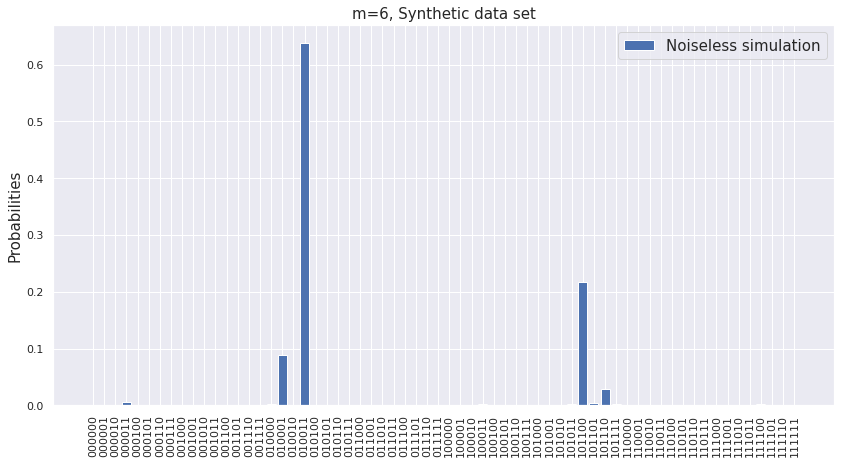

In [13]:
x = []
for n in range(64):
    x += [bin(n)[2:].zfill(len(coreset))]

plt.xticks(ticks=range(64), labels=x, rotation=90, size=11)
plt.bar(x, probabilities, width=0.8)
plt.legend(['Noiseless simulation'], fontsize=15)
plt.ylabel("Probabilities", size=15)
plt.title("m=6, Synthetic data set",size=15)

# Coreset m = 6: Problem specific ansatz

In [14]:
with open('results/results_ansatz_problem_specific_coreset_6.pickle', 'rb') as handle:
    results = pickle.load(handle)
color = []
coreset = coreset
for i in range(30):
    result = results[i]
    eigenvector = result.eigenstate if isinstance(result.eigenstate, np.ndarray) else result.eigenstate.to_matrix()
    #print(result.eigenvalue)
    probabilities = np.abs(eigenvector) ** 2
    n = probabilities.argmax()
    #print(bin(n)[2:].zfill(len(coreset)))
    
    
    if (bin(n)[2:].zfill(len(coreset)) == '100101' or bin(n)[2:].zfill(len(coreset)) == '011010'):
        color += ['b']
    else:
        color += ['blue']

/home/miriam/.local/lib/python3.8/site-packages/matplotlib/transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/miriam/.local/lib/python3.8/site-packages/matplotlib/transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


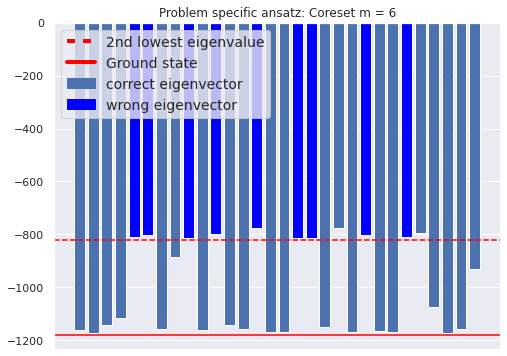

In [15]:
sns.set()
fig, ax = plt.subplots(figsize=(8, 6))

#with open('results/results_ansatz_problem_specific_coreset_6.pickle', 'rb') as handle:
#    results = pickle.load(handle)

costs = []
for i in range(30):
    costs += [results[i].eigenvalue]

ax.get_xaxis().set_visible(False)


import matplotlib.patches as mpatches
plt.bar(range(1,31), costs, width=0.8,label='_nolegend_', color=color)
groundstate_patch = mpatches.Patch(color='red', linestyle='dashed', label='Ground state')
black_patch = mpatches.Patch(color='red', label='2nd lowest eigenvalue')
groundstate_patch = mlines.Line2D([], [], linewidth=4, color='red',label='Ground state')
test = mlines.Line2D([], [], linewidth=4, linestyle="-", dashes=(2, 2),color='red',label='2nd lowest eigenvalue')
black_patch = mpatches.Patch(color='b', label='correct eigenvector')
wrong = mpatches.Patch(color='blue', label='wrong eigenvector')
plt.legend(handles=[test, groundstate_patch,black_patch,wrong],loc='upper left',frameon=True,fontsize=14)


plt.axhline(y=-822, color='red', linestyle='--', label='2nd lowest eigenvalue')
plt.axhline(y=-1180, color='red', linestyle='-', label='Ground state')
plt.title('Problem specific ansatz: Coreset m = 6')
plt.savefig("figures/results_costs_problem_specific_ansatz_coreset_6.pdf" )

# Coreset_10_2: General TwoLocal ansatz

In [16]:
with open('results/results_ansatz2_coreset_10_2.pickle', 'rb') as handle:
    results = pickle.load(handle)
color = []
coreset = coreset_10_2
for i in range(30):
    result = results[i]
    eigenvector = result.eigenstate if isinstance(result.eigenstate, np.ndarray) else result.eigenstate.to_matrix()
    #print(result.eigenvalue)
    probabilities = np.abs(eigenvector) ** 2
    n = probabilities.argmax()
    #print(bin(n)[2:].zfill(len(coreset)))
    
    
    if (bin(n)[2:].zfill(len(coreset)) == '1000110011' or bin(n)[2:].zfill(len(coreset)) == '0111001100'):
        color += ['b']
    else:
        color += ['blue']
    #print(bin(probabilities.argmax()))


# 26 = 16+8+2 = 011010
# 37 = 32 + 4 +1 = 100101

/home/miriam/.local/lib/python3.8/site-packages/matplotlib/transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


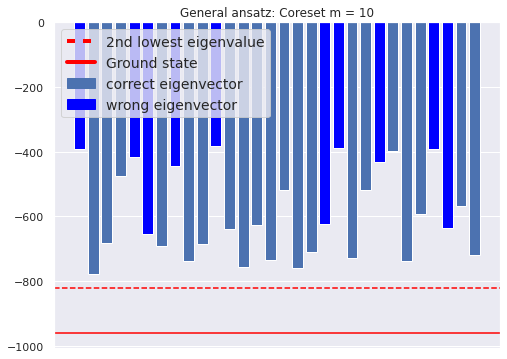

In [17]:
sns.set()
fig, ax = plt.subplots(figsize=(8, 6))

with open('results/results_ansatz2_coreset_10_2.pickle', 'rb') as handle:
    results = pickle.load(handle)

costs = []
for i in range(30):
    costs += [results[i].eigenvalue]


ax.get_xaxis().set_visible(False)

plt.bar(range(1,31), costs, width=0.8,label='_nolegend_', color=color)
groundstate_patch = mpatches.Patch(color='red', linestyle='dashed', label='Ground state')
black_patch = mpatches.Patch(color='red', label='2nd lowest eigenvalue')
groundstate_patch = mlines.Line2D([], [], linewidth=4, color='red',label='Ground state')
test = mlines.Line2D([], [], linewidth=4, linestyle="-", dashes=(2, 2),color='red',label='2nd lowest eigenvalue')
black_patch = mpatches.Patch(color='b', label='correct eigenvector')
wrong = mpatches.Patch(color='blue', label='wrong eigenvector')
plt.legend(handles=[test, groundstate_patch,black_patch,wrong],loc='upper left',frameon=True,fontsize=14)


plt.axhline(y=-822, color='red', linestyle='--', label='2nd lowest eigenvalue')
plt.axhline(y=-960, color='red', linestyle='-', label='Ground state')
plt.title('General ansatz: Coreset m = 10')
plt.savefig("figures/results_costs_TwoLocal_coreset_10.pdf" )

# Coreset_10_2: Problem specific ansatz

In [18]:
with open('results/results_ansatz_problem_specific_coreset_10_2.pickle', 'rb') as handle:
    results = pickle.load(handle)
color = []
coreset = coreset_10_2
for i in range(30):
    result = results[i]
    eigenvector = result.eigenstate if isinstance(result.eigenstate, np.ndarray) else result.eigenstate.to_matrix()
    #print(result.eigenvalue)
    probabilities = np.abs(eigenvector) ** 2
    n = probabilities.argmax()
    #print(bin(n)[2:].zfill(len(coreset)))
    
    
    if (bin(n)[2:].zfill(len(coreset)) == '1000110011' or bin(n)[2:].zfill(len(coreset)) == '0111001100'):
        color += ['b']
    else:
        color += ['blue']

/home/miriam/.local/lib/python3.8/site-packages/matplotlib/transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


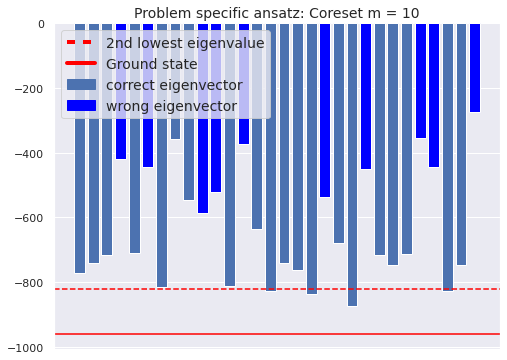

In [19]:
sns.set()
fig, ax = plt.subplots(figsize=(8, 6))

with open('results/results_ansatz_problem_specific_coreset_10_2.pickle', 'rb') as handle:
    results = pickle.load(handle)

costs = []
for i in range(30):
    costs += [results[i].eigenvalue]


ax.xaxis.set_ticks_position("top")
ax.spines['top'].set_visible(False)


import matplotlib.patches as mpatches
import matplotlib.lines as mlines
plt.bar(range(1,31), costs, width=0.8,label='_nolegend_',color=color)
groundstate_patch = mlines.Line2D([], [], linewidth=4, color='red',label='Ground state')
test = mlines.Line2D([], [], linewidth=4, linestyle="-", dashes=(2, 2),color='red',label='2nd lowest eigenvalue')
black_patch = mpatches.Patch(color='b', label='correct eigenvector')
wrong = mpatches.Patch(color='blue', label='wrong eigenvector')
plt.legend(handles=[test, groundstate_patch,black_patch,wrong],loc='upper left',frameon=True,fontsize=14)

#red_patch = mpatches.Patch(color='blue', label='Uniform')
#black_patch = mpatches.Patch(color='red', label='Coreset')
#green_patch = mpatches.Patch(color='green', label='Original')

plt.title("Problem specific ansatz: Coreset m = 10",fontsize=14)
plt.axhline(y=-822, color='red', linestyle='--', label='2nd lowest eigenvalue')
plt.axhline(y=-960, color='red', linestyle='-', label='Ground state')
ax.get_xaxis().set_visible(False)
plt.savefig("figures/results_costs_problem_specific_ansatz_coreset_10.pdf" )